# Import Packages, define fuctions

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import metcalc
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import xesmf as xe

In [2]:
def anomaly_from_tropical_mean(ds, lat=20) :
    return ds.sel(lat=slice(-lat,lat)) - metcalc.xr_fldmean(ds.sel(lat=slice(-lat,lat)))

In [3]:
def int_2_global(ds) :
    os.chdir("/work/mh0066/m300577/xesmf_weights/")
    ds_out = xr.Dataset({
                    'lat': (['lat'], np.arange(-89, 89, 2.0)),
                    'lon': (['lon'], np.arange(1, 361, 2.0)),
                    }
                    )

    regridder = xe.Regridder(ds, ds_out, "bilinear", periodic=True)
    # for large grids, like the ERA5, we need to spefify this:
    # (https://github.com/JiaweiZhuang/xESMF/issues/71)
    regridder._grid_in = None
    regridder._grid_out = None

    return regridder(ds)
    os.chdir("/home/mpim/m300577/scripts")


In [4]:
def read_mm_files(filenames,index=73) :
    def preproc(ds):
        filename = ds.encoding['source']
        month=filename[index]
        if 'plev' in ds.coords :
            ds.coords['plev2'] = ds.plev / 100
            ds = ds.swap_dims({'plev': 'plev2'})
            ds.plev2['units'] = 'hPa'
        ds['month'] = int(month)
        return ds

    return xr.open_mfdataset(filenames,concat_dim="month", combine='nested',preprocess=preproc)

# Read data

In [5]:
WORK_DIR="/work/mh0066/m300577/perpetual_jan"

In [6]:
dap0013_ta = read_mm_files(f"{WORK_DIR}/dap0013-dc/dap0013-dc_ta_20N-20S_19790?_timemean.nc",index=73)
dap0014_ta = read_mm_files(f"{WORK_DIR}/dap0014-dc/dap0014-dc_ta_20N-20S_19790?_timemean.nc",index=73)


In [7]:
dap0013_hus = read_mm_files(f"{WORK_DIR}/dap0013-dc/dap0013-dc_hus_20N-20S_19790?_timemean.nc",index=74)
dap0014_hus = read_mm_files(f"{WORK_DIR}/dap0014-dc/dap0014-dc_hus_20N-20S_19790?_timemean.nc",index=74)


In [8]:
dap0013_ts = read_mm_files(f"{WORK_DIR}/dap0013-dc/dap0013-dc_ts_20N-20S_19790?_timemean.nc",index=73)
dap0014_ts = read_mm_files(f"{WORK_DIR}/dap0014-dc/dap0014-dc_ts_20N-20S_19790?_timemean.nc",index=73)


In [9]:
dap0013_pr = read_mm_files(f"{WORK_DIR}/dap0013-dc/dap0013-dc_pr_20N-20S_19790?_timemean.nc",index=73)
dap0014_pr = read_mm_files(f"{WORK_DIR}/dap0014-dc/dap0014-dc_pr_20N-20S_19790?_timemean.nc",index=73)


In [10]:
mask_high_ = xr.open_dataset("/work/mh0066/m300577/perpetual_jan/bc_land_frac_R02B09_int_01x01.nc")
mask_high = mask_high_.sea.where(mask_high_.sea > 0.9)
mask_low_ = int_2_global(mask_high_)
mask_low = mask_low_.sea.where(mask_low_.sea > 0.9)

## Preprocess data

In [11]:
dap0013_ta["SST"] = dap0013_ts.ts * mask_high
dap0014_ta["SST"] = dap0014_ts.ts * mask_high
dap0013_ta["ts"] = dap0013_ts.ts
dap0014_ta["ts"] = dap0014_ts.ts
dap0013_ta["hus"] = dap0013_hus.hus
dap0014_ta["hus"] = dap0014_hus.hus


dap0013_ta["pr"] = dap0013_pr.pr *3600. *24. # convert to mm/day
dap0014_ta["pr"] = dap0014_pr.pr *3600. *24.

dap0013_ta["Tv"] = metcalc.virtual_temperature(dap0013_ta.ta,dap0013_ta.hus)
dap0014_ta["Tv"] = metcalc.virtual_temperature(dap0014_ta.ta,dap0014_ta.hus)

dap0013_ta["theta"] = metcalc.xr_potential_temperature(dap0013_ta)
dap0014_ta["theta"] = metcalc.xr_potential_temperature(dap0014_ta)

dap0013_ta["MSE"] = metcalc.xr_MSE(dap0013_ta.ta,dap0013_ta.hus)
dap0014_ta["MSE"] = metcalc.xr_MSE(dap0014_ta.ta,dap0014_ta.hus)
dap0013_ta["Phi"] = metcalc.xr_geopotential(dap0013_ta.Tv).Phi
dap0014_ta["Phi"] = metcalc.xr_geopotential(dap0014_ta.Tv).Phi
dap0013_ta["500_200_thick"] = metcalc.xr_thickness(dap0013_ta.Tv,500,200)
dap0014_ta["500_200_thick"] = metcalc.xr_thickness(dap0014_ta.Tv,500,200)
dap0013_ta["400_200_thick"] = metcalc.xr_thickness(dap0013_ta.Tv,400,200)
dap0014_ta["400_200_thick"] = metcalc.xr_thickness(dap0014_ta.Tv,400,200)
dap0013_ta["400_150_thick"] = metcalc.xr_thickness(dap0013_ta.Tv,400,150)
dap0014_ta["400_150_thick"] = metcalc.xr_thickness(dap0014_ta.Tv,400,150)
dap0013_ta["700_200_thick"] = metcalc.xr_thickness(dap0013_ta.Tv,700,200)
dap0014_ta["700_200_thick"] = metcalc.xr_thickness(dap0014_ta.Tv,700,200)
dap0013_ta["700_400_thick"] = metcalc.xr_thickness(dap0013_ta.Tv,700,400)
dap0014_ta["700_400_thick"] = metcalc.xr_thickness(dap0014_ta.Tv,700,400)

dap0014_ta = dap0014_ta.compute()
dap0013_ta = dap0013_ta.compute()

In [12]:

dap0013_ta_LR = dap0013_ta.coarsen(lon=10, lat=10).mean()
dap0014_ta_LR = dap0014_ta.coarsen(lon=10, lat=10).mean()


In [13]:
dap_diff = dap0014_ta.mean("month") - dap0013_ta.mean("month")
dap_diff_LR = dap0014_ta_LR.mean("month") - dap0013_ta_LR.mean("month")

dap_diff_an = anomaly_from_tropical_mean(dap_diff)
dap_diff_an_LR = anomaly_from_tropical_mean(dap_diff_LR)

## Correlation between SST and 300hPa temperature

In [14]:
xr.corr(dap_diff_an.SST.stack(coord=("lon", "lat")),dap_diff_an.sel(plev2=300).ta.stack(coord=("lon", "lat")),"coord")

<xarray.DataArray ()>
array(0.40077534)
Coordinates:
    plev     float64 3e+04
    plev2    float64 300.0

In [15]:
xr.corr(dap_diff_an.SST.stack(coord=("lon", "lat")),dap_diff_an["400_150_thick"].stack(coord=("lon", "lat")),"coord")

<xarray.DataArray ()>
array(0.31752033)

# Read CMIP

In [16]:
CMIP_DIR="/work/mh0066/m300577/cmip6/ssp585"

In [17]:
ssp585 = xr.open_mfdataset( f"{CMIP_DIR}/ta/ta_ssp585_*mm_jan_global2x2.nc",concat_dim="model_id", combine='nested')
ssp585_pr_ = xr.open_mfdataset( f"{CMIP_DIR}/pr/pr_ssp585_*mm_jan_global2x2.nc",concat_dim="model_id", combine='nested')
ssp585["ts"] = xr.open_mfdataset(f"{CMIP_DIR}/ts/ts_ssp585_*_mm_jan_global2x2.nc",concat_dim="model_id", combine='nested').ts
ssp585["hus"] = xr.open_mfdataset(f"{CMIP_DIR}/hus/hus_ssp585_*_mm_jan_global2x2.nc",concat_dim="model_id", combine='nested').hus
ssp585["pr"] = ssp585_pr_.pr

ssp585["time"] = np.arange(2015,2100)
ssp585["SST"] = ssp585["ts"] * mask_low


In [18]:
if 'plev' in ssp585.coords :
    ssp585.coords['plev2'] = ssp585.plev / 100
    ssp585 = ssp585.swap_dims({'plev': 'plev2'})
    ssp585.plev2['units'] = 'hPa'

In [19]:
ssp585["Tv"] = metcalc.virtual_temperature(ssp585.ta,ssp585.hus)

ssp585["500_200_thick"] = metcalc.xr_thickness(ssp585.Tv,500,200)
ssp585["400_200_thick"] = metcalc.xr_thickness(ssp585.Tv,400,200)
ssp585["700_200_thick"] = metcalc.xr_thickness(ssp585.Tv,700,200)
ssp585["400_150_thick"] = metcalc.xr_thickness(ssp585.Tv,400,150)

In [20]:
ssp585_early = ssp585.sel(time=slice(2015,2034)).mean("time") 
ssp585_early_an =  anomaly_from_tropical_mean(ssp585_early)
ssp585_diff = ssp585.sel(time=slice(2080,2099)).mean("time") - ssp585_early
ssp585_diff_an = anomaly_from_tropical_mean(ssp585_diff)
ssp585_diff_an_ens = ssp585_diff_an.mean("model_id")
ssp585_diff_tropical_mean = metcalc.xr_fldmean(ssp585_diff.sel(lat=slice(-20,20)))

In [21]:
ssp585_diff_tropical_mean["warming_std"] = ssp585_diff_an.sel(lat=slice(-20,20)).ta.std(["lon","lat"])
ssp585_diff_tropical_mean["warming_std_2"] = ssp585_diff_an.sel(lat=slice(-15,15)).ta.std(["lon","lat"])
ssp585_diff_tropical_mean["warming_std_zonal"] = ssp585_diff_an.sel(lat=slice(-20,20)).ta.std("lon").mean("lat")

## Correlation between SST and 300hPa temperature

In [22]:
xr.corr(ssp585_diff_an.SST.stack(coord=("lon", "lat")),ssp585_diff_an.sel(plev2=300).ta.stack(coord=("lon", "lat")),"coord").compute().mean("model_id")

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


<xarray.DataArray ()>
array(0.19576511)
Coordinates:
    member_id  <U8 'r1i1p1f1'
    plev       float64 3e+04
    plev2      float64 300.0

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


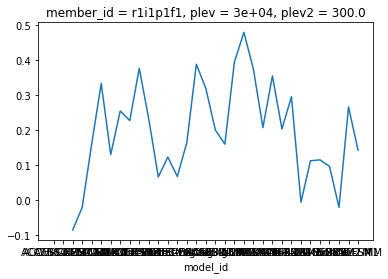

In [23]:
xr.corr(ssp585_diff_an.SST.stack(coord=("lon", "lat")),ssp585_diff_an.sel(plev2=300).ta.stack(coord=("lon", "lat")),"coord").compute().plot()

# Plotting

In [24]:
!mkdir -p ../plots

## Maps of SSTs and upper tropospheric warming

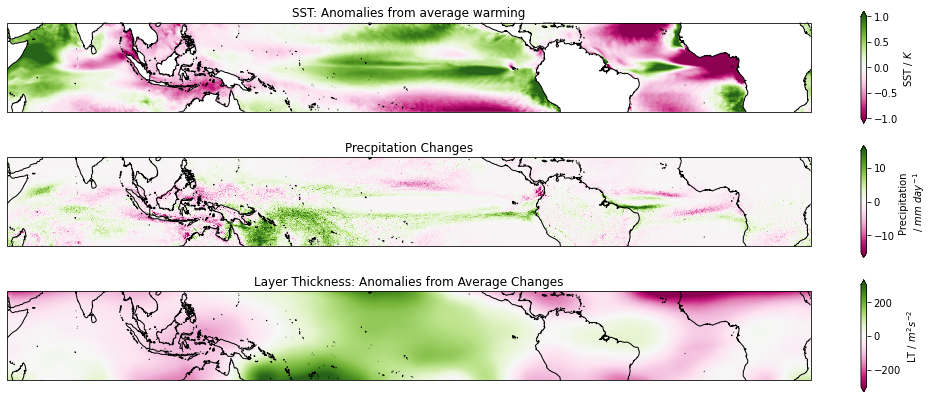

In [25]:
fig,xs = plt.subplots(3,1,figsize=(18,7), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=222)})

ax=xs[0]
im =  dap_diff_an.SST.plot(x="lon",y="lat",vmin=-1,vmax=1,ax=ax,cmap='PiYG',add_colorbar=True,cbar_kwargs={"label": "SST / $K$"},transform=ccrs.PlateCarree())
ax.set_title("SST: Anomalies from average warming")
metcalc.set_regional_cartopy(ax)

ax=xs[1]
im =  dap_diff_an.pr.plot(x="lon",y="lat",ax=ax,vmin=-15,vmax=15,cmap='PiYG',add_colorbar=True,cbar_kwargs={"label": "Precipitation \n/ $mm \ day^{-1}$"},transform=ccrs.PlateCarree())
ax.set_title("Precpitation Changes")
metcalc.set_regional_cartopy(ax)

ax=xs[2]
im =  dap_diff_an["400_200_thick"].plot(x="lon",y="lat",vmin=-300,vmax=300,ax=ax,cmap='PiYG',add_colorbar=True,cbar_kwargs={"label": "LT / $m^2 s^{-2}$"},transform=ccrs.PlateCarree())
ax.set_title("Layer Thickness: Anomalies from Average Changes")
metcalc.set_regional_cartopy(ax)


In [26]:
plt.rc('font',size=10)

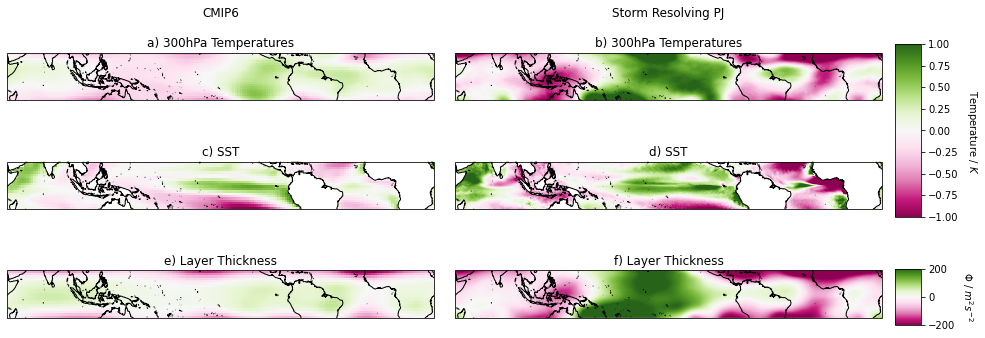

In [27]:
fig,xs = plt.subplots(3,2,figsize=(18,6),facecolor="white", subplot_kw={'projection': ccrs.PlateCarree(central_longitude=222)})

ax=xs[0,0]
im = ssp585_diff_an_ens.sel(plev2=300).ta.plot(x="lon",y="lat",vmin=-1,vmax=1,ax=ax,cmap='PiYG',add_colorbar=False,transform=ccrs.PlateCarree())
ax.set_title("CMIP6\n\na) 300hPa Temperatures")
metcalc.set_regional_cartopy(ax)

ax=xs[1,0]
im =  ssp585_diff_an_ens.SST.plot(x="lon",y="lat",vmin=-1,vmax=1,ax=ax,cmap='PiYG',add_colorbar=False,transform=ccrs.PlateCarree())
ax.set_title("c) SST")
metcalc.set_regional_cartopy(ax)

ax=xs[2,0]
im =  ssp585_diff_an_ens["400_150_thick"].plot(x="lon",y="lat",vmin=-200,vmax=200,ax=ax,cmap='PiYG',add_colorbar=False,transform=ccrs.PlateCarree())
ax.set_title("e) Layer Thickness")
metcalc.set_regional_cartopy(ax)


ax=xs[0,1]
im =  dap_diff_an.ta.sel(plev2=300).plot(x="lon",y="lat",ax=ax,vmin=-1,vmax=1,cmap='PiYG',add_colorbar=False,transform=ccrs.PlateCarree())
ax.set_title("Storm Resolving PJ\n\nb) 300hPa Temperatures")
metcalc.set_regional_cartopy(ax)

ax=xs[1,1]
im =  dap_diff_an.SST.plot(x="lon",y="lat",vmin=-1,vmax=1,ax=ax,cmap='PiYG',add_colorbar=False,transform=ccrs.PlateCarree())
ax.set_title("d) SST")
metcalc.set_regional_cartopy(ax)

#fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.43, 0.02, 0.4])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(' Temperature / $K$', rotation=270,labelpad=20)

ax=xs[2,1]
im =  dap_diff_an["400_150_thick"].plot(x="lon",y="lat",vmin=-200,vmax=200,ax=ax,cmap='PiYG',add_colorbar=False,transform=ccrs.PlateCarree())
ax.set_title("f) Layer Thickness")
metcalc.set_regional_cartopy(ax)

fig.subplots_adjust(right=0.8,wspace=0.05,hspace=0)
cbar_ax = fig.add_axes([0.81, 0.18, 0.02, 0.13])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("$\Phi$ / $m^2 s^{-2}$", rotation=270,labelpad=20)

plt.savefig('../plots/figure1.png', dpi=600,bbox_inches='tight')


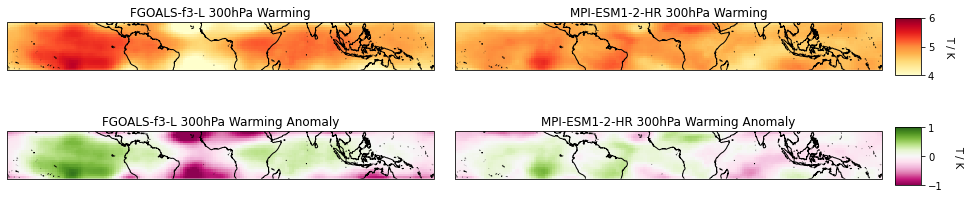

In [28]:
fig,xs = plt.subplots(2,2,figsize=(18,4), subplot_kw={'projection': ccrs.PlateCarree()})


model1 = ssp585_diff_an.isel(model_id=15).model_id.values
model2 = ssp585_diff_an.isel(model_id=26).model_id.values

ax=xs[0,0]
im = ssp585_diff.sel(model_id=model1).sel(plev2=300).ta.plot(x="lon",y="lat",vmin=4,vmax=6,ax=ax,cmap='YlOrRd',add_colorbar=False)
ax.set_title(f"{model1} 300hPa Warming")
metcalc.set_regional_cartopy(ax)

ax=xs[0,1]
im = ssp585_diff.sel(model_id=model2).sel(plev2=300).ta.plot(x="lon",y="lat",vmin=4,vmax=6,ax=ax,cmap='YlOrRd',add_colorbar=False)
ax.set_title(f"{model2} 300hPa Warming")
metcalc.set_regional_cartopy(ax)

fig.subplots_adjust(right=0.8,wspace=0.05,hspace=0)
cbar_ax = fig.add_axes([0.81, 0.59, 0.02, 0.2])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("T / K", rotation=270,labelpad=20)

ax=xs[1,0]
im = ssp585_diff_an.sel(model_id=model1).sel(plev2=300).ta.plot(x="lon",y="lat",vmin=-1,vmax=1,ax=ax,cmap='PiYG',add_colorbar=False)
ax.set_title(f"{model1} 300hPa Warming Anomaly")
metcalc.set_regional_cartopy(ax)

ax=xs[1,1]
im = ssp585_diff_an.sel(model_id=model2).sel(plev2=300).ta.plot(x="lon",y="lat",vmin=-1,vmax=1,ax=ax,cmap='PiYG',add_colorbar=False)
ax.set_title(f"{model2} 300hPa Warming Anomaly")
metcalc.set_regional_cartopy(ax)


fig.subplots_adjust(right=0.8,wspace=0.05,hspace=0)
cbar_ax = fig.add_axes([0.81, 0.21, 0.02, 0.2])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("T / K", rotation=270,labelpad=20)

## Verical Profile of Tropical Mean Warming

In [29]:
tropical_mean_ta = metcalc.xr_fldmean(dap_diff.ta) / metcalc.xr_fldmean(dap_diff.ta.sel(plev2=1000))
tropical_mean_ta_ssp585 = metcalc.xr_fldmean(ssp585_diff.ta.sel(lat=slice(-20,20))) / metcalc.xr_fldmean(ssp585_diff.ta.sel(lat=slice(-20,20)).sel(plev2=1000))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


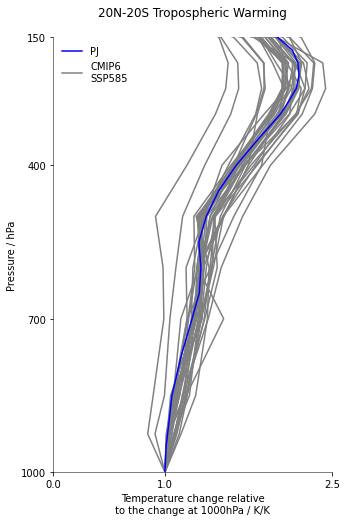

In [30]:
fig,ax2 = plt.subplots(figsize=(5,8),facecolor="white")

tropical_mean_ta.plot(y="plev2",ax=ax2,color="blue",zorder=2)
tropical_mean_ta_ssp585.plot(y="plev2",ax=ax2,hue="model_id",color="grey",zorder=1)

ax2.set_ylim(1000,150)
metcalc.remove_axes(ax2)
ax2.set_ylabel("Pressure / hPa")
ax2.set_xlabel("Temperature change relative\n to the change at 1000hPa / K/K ")
ax2.legend().remove()
ax2.set_xlim(0,2.5)
ax2.set_title("20N-20S Tropospheric Warming\n")
ax2.legend(["PJ","CMIP6\nSSP585"],loc="upper left",frameon=False)
ax2.set_yticks([1000,700,400,150])
ax2.set_xticks([0,1,2.5])

plt.savefig('../plots/warming_profile.png', dpi=600,bbox_inches='tight')


# Calculate Some paramters we need for the non-dimensionalisation

Static Stability

$$ S = \frac{\partial \Phi}{\partial p} \frac{d log(\theta)}{dp} $$

In [31]:
def calc_alpha(delta_Phi,d_log_theta_d_p,p1,p2,p3,p0=0,p4=100000.) :
    
    dPhidp = delta_Phi / (p3-p1)
    a = (p1- p3) / (1./(p2-p4) + 1./(p0-p2))
    
    return dPhidp * d_log_theta_d_p * a

Typical layer thicknesses:

In [32]:
dap0013_ta["400_150_thick"].mean()

<xarray.DataArray '400_150_thick' ()>
array(64836.12479592)

In [33]:
dap0013_ta["700_200_thick"].mean()

<xarray.DataArray '700_200_thick' ()>
array(90703.70892667)

In [34]:
dap0013_ta["700_400_thick"].mean()

<xarray.DataArray '700_400_thick' ()>
array(43371.41652708)

$ log(\theta (700) - \theta (200)) $

In [35]:
theta_700_200_dap0013 = np.log(dap0013_ta["theta"].mean(["month","lon","lat"]).sel(plev2=700)) - np.log(dap0013_ta["theta"].mean(["month","lon","lat"]).sel(plev2=200))

In [36]:
theta_700_200_dap0014 = np.log(dap0014_ta["theta"].mean(["month","lon","lat"]).sel(plev2=700)) - np.log(dap0014_ta["theta"].mean(["month","lon","lat"]).sel(plev2=200))

In [37]:

p1_700_200=20000.
p2_700_200=45000.
p3_700_200=70000.

print(calc_alpha(dap0013_ta["700_200_thick"].mean(),theta_700_200_dap0013/(p1_700_200-p3_700_200),p1_700_200,p2_700_200,p3_700_200).values)
print(calc_alpha(dap0014_ta["700_200_thick"].mean(),theta_700_200_dap0014/(p1_700_200-p3_700_200),p1_700_200,p2_700_200,p3_700_200).values)

4618.310375003841
5399.034963640833


$ log(\theta (400) - \theta (150)) $

In [38]:
theta_400_150_dap0013 = np.log(dap0013_ta["theta"].mean(["month","lon","lat"]).sel(plev2=400)) - np.log(dap0013_ta["theta"].mean(["month","lon","lat"]).sel(plev2=150))

In [39]:
theta_400_150_dap0014 = np.log(dap0014_ta["theta"].mean(["month","lon","lat"]).sel(plev2=400)) - np.log(dap0014_ta["theta"].mean(["month","lon","lat"]).sel(plev2=150))

In [40]:
p1_400_150=15000.
p2_400_150=27500.
p3_400_150=40000.


alpha_400_150_dap0013= calc_alpha(dap0013_ta["400_150_thick"].mean(),theta_400_150_dap0013/(p1_400_150-p3_400_150),p1_400_150,p2_400_150,p3_400_150).values
alpha_400_150_dap0014= calc_alpha(dap0014_ta["400_150_thick"].mean(),theta_400_150_dap0014/(p1_400_150-p3_400_150),p1_400_150,p2_400_150,p3_400_150).values

print(alpha_400_150_dap0013)
print(alpha_400_150_dap0014)

2936.5648117331725
3493.212386855116


In [41]:
print((alpha_400_150_dap0013-alpha_400_150_dap0014)/alpha_400_150_dap0013)

-0.18955739471433902


In [42]:
S_400_150_dap0013 = theta_400_150_dap0013/25000. * dap0013_ta["400_150_thick"].mean(["month","lon","lat"])/25000.

In [43]:
S_400_150_dap0014 = theta_400_150_dap0014/25000. * dap0014_ta["400_150_thick"].mean(["month","lon","lat"])/25000.

In [44]:
print(S_400_150_dap0013)

<xarray.DataArray ()>
array(-5.89154069e-06)


In [45]:
print(S_400_150_dap0014)

<xarray.DataArray ()>
array(-7.00832579e-06)


In [46]:
theta_700_400_dap0013 = np.log(dap0013_ta["theta"].mean(["month","lon","lat"]).sel(plev2=700)) - np.log(dap0013_ta["theta"].mean(["month","lon","lat"]).sel(plev2=400))

In [47]:
theta_700_400_dap0014 = np.log(dap0014_ta["theta"].mean(["month","lon","lat"]).sel(plev2=700)) - np.log(dap0014_ta["theta"].mean(["month","lon","lat"]).sel(plev2=400))

In [48]:
p1_700_400=40000.
p2_700_400=55000.
p3_700_400=70000.


alpha_700_400_dap0013= calc_alpha(dap0013_ta["700_400_thick"].mean(),theta_700_400_dap0013/(p1_700_400-p3_700_400),p1_700_400,p2_700_400,p3_700_400).values
alpha_700_400_dap0014= calc_alpha(dap0014_ta["700_400_thick"].mean(),theta_700_400_dap0014/(p1_700_400-p3_700_400),p1_700_400,p2_700_400,p3_700_400).values

print(alpha_700_400_dap0013)
print(alpha_700_400_dap0014)

2254.918268581312
2483.710742227349
